In [70]:
import glob

import numpy as np
from pylab import *


def read_ps_voltage(file):
    read_data = np.genfromtxt(file, skip_header=1, delimiter=',')
    return read_data[:, 1]

# Messungen

Wir haben angefangen 20 verschiedene Entfernungen zu messen und diese mit der Picoscope Software in 20 einzelne CSV Dateien gespeichert.

In [71]:
files = glob.glob("cleaned/*cm*.csv")

# [reference in mm, all voltage values]
data = {
    100: read_ps_voltage(files[0]),
    130: read_ps_voltage(files[1]),
    160: read_ps_voltage(files[2]),
    180: read_ps_voltage(files[3]),
    220: read_ps_voltage(files[4]),
    245: read_ps_voltage(files[5]),
    250: read_ps_voltage(files[6]),
    280: read_ps_voltage(files[7]),
    300: read_ps_voltage(files[8]),
    340: read_ps_voltage(files[9]),
    380: read_ps_voltage(files[10]),
    410: read_ps_voltage(files[11]),
    460: read_ps_voltage(files[12]),
    490: read_ps_voltage(files[13]),
    520: read_ps_voltage(files[14]),
    580: read_ps_voltage(files[15]),
    620: read_ps_voltage(files[16]),
    650: read_ps_voltage(files[17]),
    690: read_ps_voltage(files[18]),
    710: read_ps_voltage(files[19]),
}

data_mean = {k: np.mean(v) for k, v in data.items()}

measurements = np.array(list(data_mean.items()))

# Plotten und Logarithm

Wir können jetzt diese daten plotten. Sie haben die form $y = x^a$ deswegen müssen wir sie logarithmieren.

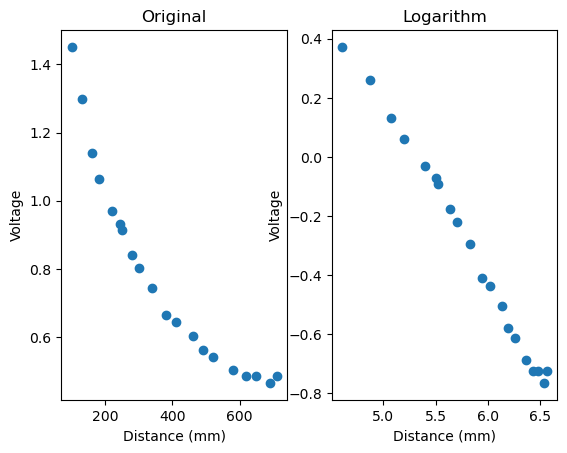

In [72]:
subplot(1, 2, 1)
scatter(measurements[:, 0], measurements[:, 1])

title("Original")
xlabel("Distance (mm)")
ylabel("Voltage")

log_distance = np.log(measurements[:, 0])
log_voltage = np.log(measurements[:, 1])

subplot(1, 2, 2)
scatter(log_distance, log_voltage)

title("Logarithm")
xlabel("Distance (mm)")
ylabel("Voltage")

show()

# Lineare Regression

Jetzt können wir für die lineare Regression $a$ und $b$ berechnen.

Wir verwenden:

$a=\frac{\sum_{i=1}^{n}(x_i-\bar{x})*(y_i-\bar{y})}{\sum_{i=1}^{n}(x_i-\bar{x})^2}$ und $b=\bar{y}-a*\bar{x}$

In [73]:
x = log_distance
y = log_voltage

x_mean = np.mean(x)
y_mean = np.mean(y)

a = np.divide(np.sum((x - x_mean) * (y - y_mean)),
              np.sum((x - x_mean) ** 2))

b = y_mean - a * x_mean

Das plotten wir noch.

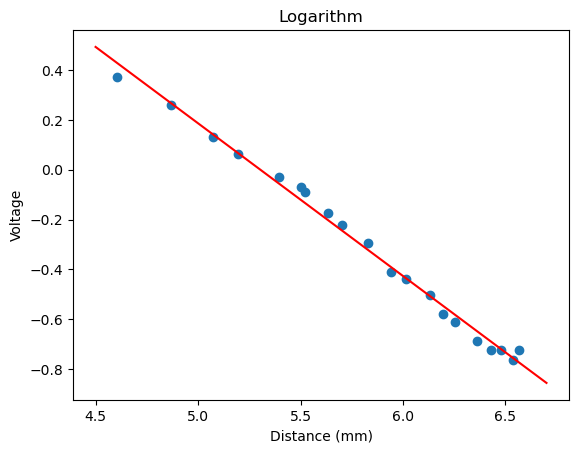

In [74]:
lin = np.linspace(4.5, 6.7)
y_lin = a * lin + b

figure()

scatter(log_distance, log_voltage)
plot(lin, y_lin, 'r')

title("Logarithm")
xlabel("Distance (mm)")
ylabel("Voltage")
show()